
### Генерация поэзии с помощью нейронных сетей

Хотим научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2023-12-03 16:31:07--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-03 16:31:07 (8.74 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
Требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


Обучим классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерируем последовательность длины 100 для фиксированной начальной фразы.

Далее реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Мы будем использовать ее при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83,  1, 47, ..., 45, 49, 58],
       [83, 50, 48, ..., 53, 66,  1],
       [83, 49, 59, ..., 59, 49, 53],
       ...,
       [83, 59, 46, ..., 59,  5,  0],
       [83, 45,  1, ..., 62, 50, 56],
       [83, 50, 58, ..., 57, 50, 58]])

Напишем код для обучения модели и генерации текста.

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True, dropout=0.1)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        #assert isinstance(x.data, torch.LongTensor)
        h_seq, a = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
loss_func = nn.NLLLoss()
history = []

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# the model applies over the whole sequence
batch_ix = next(generate_chunk())
batch_ix = torch.LongTensor(batch_ix)

logp_seq = F.log_softmax(model(batch_ix), dim=-1)

# compute loss.
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens),
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

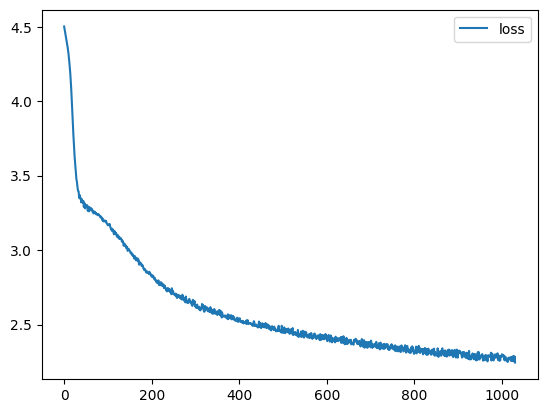

In [ ]:
for i in range(1000):
    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = F.log_softmax(model(batch_ix), dim=-1)

    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape((-1, num_tokens)), actual_next_tokens.reshape(-1))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    print(x_sequence)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
      a = char_rnn(x_sequence[:, i])

    # your code here
    for _ in range(max_length - len(seed_phrase)):
        logits_next = char_rnn(x_sequence[:, -1])
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_idx['<sos>']:
          break

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

tensor([[83,  1, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72, 66,  1, 68,
         50, 62, 63, 58, 72, 66,  1, 60, 61, 45, 47, 53, 56]])
<sos> мой дядя самых честных правилажей вой
ишужахымыхома.
пый;
ныхой:
писс любова;
огомуграза;
скоди бый?»чазай…p
ожей) ихозай…»
вый.
вомогостяй.
замой?».
нася;

мумсё
учей,
бомохий.
ой,
бой,
истий!»ce
пой, вый;
ий;
ой…
ичадахый;
скей;

пему,
ной…a»жгой тумачудазази ожихы?l
пой?»cst, возажи,
стый
xlvi
учиза!
сзугбый;
па,
ощи;
оводай€eu!»-—
пый;
нодазруя,
люй!».
поней;
дцый) дыйцый8вай,
вый.

войфда:

выщу выхоза,
прий!»» поный!.
ный!»»!
рый-ть посий
подый,
прему фвый, пай:
пий…».
«вый…
блыйё,
вый нi
